# Connecting to the IBM Quantum Platform

Simulating is very useful, but often there is no realistic substitute for running circuits on real hardware. Mostly when the problem scales in the amount of qubits (limited to 20-25 on traditional hardware). Or when the physics of the hardware need to be characterised.

Luckily IBM provides access to hardware through their cloud platform. There is a free tier of 10 minutes of runtime per month. Connecting requires an API key and is quite simple to set up. How to set up communication to the IBM cloud account can be found here: [Set up your IBM Cloud account](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup).
You will have to set up payment options with a credit card to unlock functionality. However, the plan is pay-as-you-go, so when you only use the free options you shouldn't get charged. Upgrading can be done here: https://cloud.ibm.com/billing/payments

For this we will create a simple circuit that will build all 4 Bell states and measures them. First we will explore the circuits using QuTiP.


(The *SNOT* gate is used here instead of *H*, otherwise it will give issues later when exporting the circuit as qasm, they are equivalent from the perspective of `qutip.qip.Gate`)

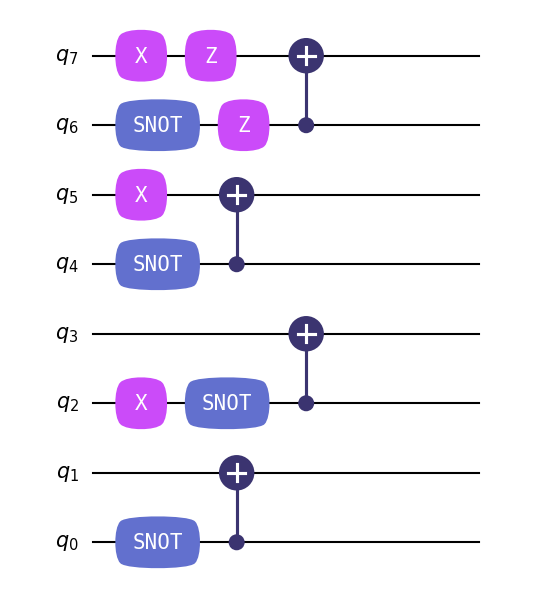

In [77]:
from qutip import tensor, basis, bell_state
from qutip_qip.circuit import QubitCircuit

qc_qutip = QubitCircuit(8)
# Create B_00 between q_0 and q_1
qc_qutip.add_gate("SNOT", 0)
qc_qutip.add_gate("CNOT", 1, 0)
# Create B_01
qc_qutip.add_gate("X", 2)
qc_qutip.add_gate("SNOT", 2)
qc_qutip.add_gate("CNOT", 3, 2)
# Create B_10
qc_qutip.add_gate("X", 5)
qc_qutip.add_gate("SNOT", 4)
qc_qutip.add_gate("CNOT", 5, 4)
# Create B_11
qc_qutip.add_gate("X", 7)
qc_qutip.add_gate("SNOT", 6)
qc_qutip.add_gate("Z", 6)
qc_qutip.add_gate("Z", 7)
qc_qutip.add_gate("CNOT", 7, 6)
qc_qutip.draw()

In [78]:
# Prepare the 8-qubit 0 state
psi = tensor([basis(2, 0) for _ in range(8)])
# Run the circuit
res = qc_qutip.run(psi)

# now we can examine the 4 subsystems (which should correspond to the 4 bell states)
# By performing a partial trace for each qubit pair.
# I have named them Bc_xx because they are *B*ell states resulting from the *c*ircuit
Bc_00 = res.ptrace([0, 1])
Bc_01 = res.ptrace([2, 3])
Bc_10 = res.ptrace([4, 5])
Bc_11 = res.ptrace([6, 7])

In [79]:
# Then, for comparison, we can grab the definitions of the Bell states from Qutip and compare
B_00 = bell_state('00')
B_01 = bell_state('01')
B_10 = bell_state('10')
B_11 = bell_state('11')
# But since the partial trace returns a density matrix, we need to convert the Bell statevectors into density matrices too for easy comparison
assert(B_00.proj() == Bc_00)
assert(B_01.proj() == Bc_01)
assert(B_10.proj() == Bc_10)
assert(B_11.proj() == Bc_11)

The asserts pass, so we have designed a circuit that creates all 4 Bell states in parallel

## Design in Qiskit

Now we need to set up the same circuit in Qiskit. We will use a sampler later on, so we will add a classical register and measurement operations

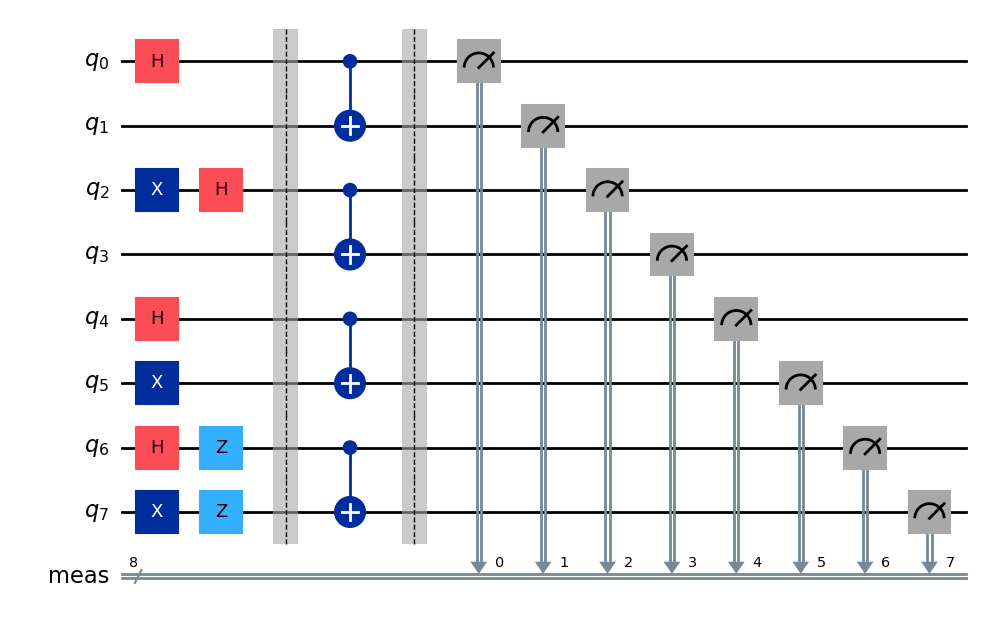

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp

qr = QuantumRegister(8, 'q')
cr = ClassicalRegister(8, 'meas') 
qc = QuantumCircuit(qr)

# B_00
qc.h(0)

# B_01
qc.x(2)
qc.h(2)

# B_10
qc.x(5)
qc.h(4)

# B_11
qc.x(7)
qc.h(6)
qc.z(6)
qc.z(7)

qc.barrier()

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(4, 5)
qc.cx(6, 7)

qc.measure_all()

qc.draw('mpl')

Though we could also export ourt circuit from QuTiP and import it into Qiskit.

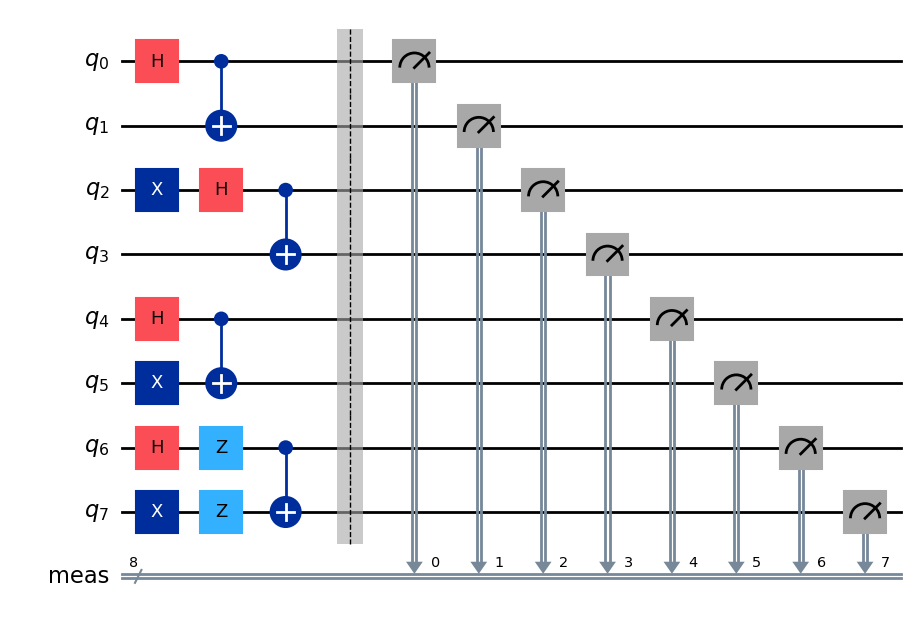

In [85]:
from qutip_qip.qasm import circuit_to_qasm_str
from qiskit.qasm2 import loads

# Build a Qasm string, this can be sotred extrenally in a file
qasm = circuit_to_qasm_str(qc_qutip)

# Load the qasm string, this can also come from a file
circuit = loads(qasm)
circuit.measure_all()
circuit.draw('mpl')

## Setting up the connection to the cloud platform

In this I assume the steps have been followed to set up account verification and that the snippet in the following cell runs successfully. For this you at least need to have access to your IBM Cloud API key, as described [here](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup).

If this was successful, you should get a list of available backends.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


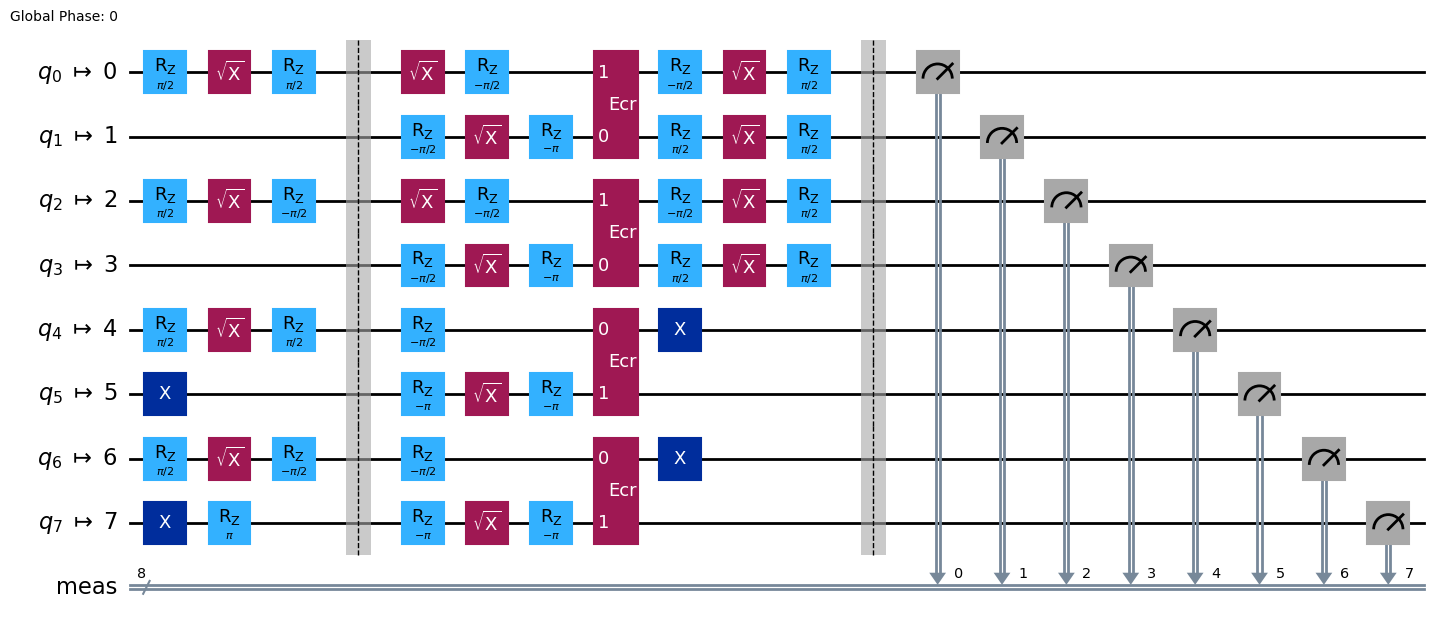

In [7]:
from qiskit.transpiler import generate_preset_pass_manager

backend = service.backend("ibm_brisbane")
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [8]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=1000)
print(job.job_id())

d340hvu6dbus73d9jlgg


The job should now show up in your IBM Cloud dashboard:

![](./images/platform_job.png)

When it is finished (in this case it should be very quick, approximately 1 second), we can get the results as we've done before.

In [11]:
results = job.result()
results[0].data.meas.get_counts()

{'01011111': 52,
 '10011100': 56,
 '10010011': 62,
 '10100100': 3,
 '01101111': 38,
 '01010011': 49,
 '01010000': 49,
 '01011100': 48,
 '00100011': 3,
 '10101111': 52,
 '01100011': 54,
 '01101100': 48,
 '10101100': 48,
 '11010000': 2,
 '10011011': 5,
 '01111111': 4,
 '10011000': 6,
 '01100000': 46,
 '01010111': 2,
 '10010111': 4,
 '01010100': 3,
 '10100011': 45,
 '01101101': 2,
 '01001100': 5,
 '10011111': 55,
 '01111110': 2,
 '10010000': 57,
 '10101101': 5,
 '01111100': 4,
 '10100111': 1,
 '10100000': 44,
 '10100001': 6,
 '10011110': 4,
 '01100010': 5,
 '10101011': 6,
 '01011000': 5,
 '01101011': 4,
 '01011101': 7,
 '01000011': 3,
 '00011111': 6,
 '01110100': 1,
 '10010001': 4,
 '10110011': 3,
 '01100111': 1,
 '01010001': 7,
 '10011101': 7,
 '10111110': 1,
 '00100000': 2,
 '01011110': 1,
 '11101111': 3,
 '10111111': 6,
 '10101110': 5,
 '01110011': 3,
 '00011100': 4,
 '00010000': 3,
 '11100000': 3,
 '01001011': 1,
 '01011011': 2,
 '10001100': 1,
 '00101100': 3,
 '01110000': 3,
 '011011

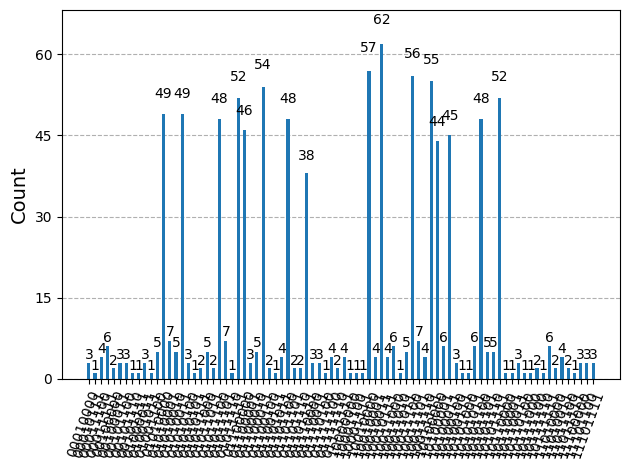

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(results[0].data.meas.get_counts())

What we would expect here is that the states corresponding to Bell states are stronger. Let's filter the values below 7 and plot again.

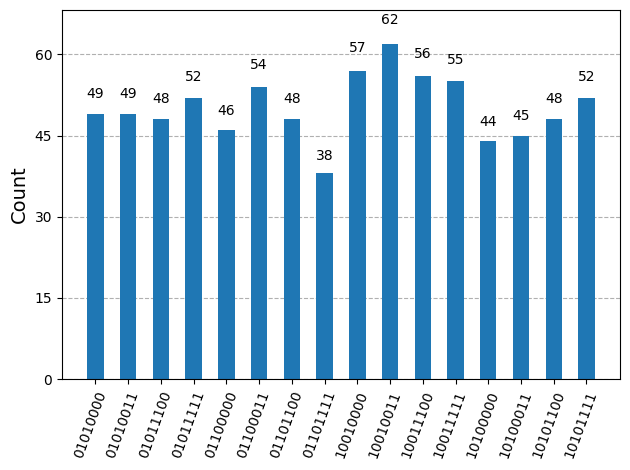

In [13]:
plot_histogram({k:v for k, v in results[0].data.meas.get_counts().items() if v > 7})

The result reports the registers as `{q7...q0}`, so we can see here that q0 and q1 are alwasy the same as expected from having generated a Bell state. Same goes for q2 and q3. The other qubits are always opposite in the pairs q4,q5 and q6, q7. This is exactly what you would expect here. We filtered out all values lower than 7, as these represent the noise that goes on in the system.